# Final Project: Predicting if a restaurant in Chicago will go out of business based on City of Chicago food inspection data

## Summary of Analysis:
My initial proposal for predicting if a restaurant will go out of business did not consider natrual language processing. Instead, I was going to rely on the number of violations a restaurant received as my main feature to predict if a restaurant will go out of business. Through initial EDA, I found out that there wasn't a strong relationship between the number of violations and whether or not a restaurant will go out of business.

From this point, I decided to rely on the text of the violation to predict since my other features also didn't have as strong of a correlation.

After deciding to use natural language processing for prediction I debated the two machine learning models below:
1)Logistic Regression
2)Naive Bayes

--
Based on tests across the two models, I decided naive bayes was the best model to use for predictions due to it's accuracy and precision compared to the null model of the data set.

Additionaly, I went with Naive Bayes because considered the probability of an outcome and is able to classify data (predict). Compared to logistic regression, which just returns the numeric probability of an outcome, naive bayes gave me contextual outcome (prediction) I was looking for. 

In using naive bayes, the model was able to predict if a restaurant would go out of business with 89% accuracy vs the 10% accuracy of a null model. This suggested that the model picked up on features and thier ability to predict if a restaurant would go out of business.


<br>
  
  
  
  
  

### EDA (Parsed down to include essential information from initial EDA Project)

In [181]:
#Import Pandas ad pd and Matplotlib as plt

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [182]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
precision_score, recall_score
from nltk.stem.snowball import SnowballStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob, Word

#### Perform statistical analysis, along with any visualizations.

In [183]:
#Read food inspection data 

#Assign the data set to the data frame 'inspections' 

inspections_path = Path('data','Food_Inspections.csv')

inspections = pd.read_csv(inspections_path, header=0, error_bad_lines=False)


#Replace spaces in column names with '_' character

inspections.columns = inspections.columns.str.replace(' ', '_')

#Replace special character in violations columns with ':::'. This is being done in order to count number of violations per restaurant in the future
inspections.loc[:,'Violations_New'] = inspections.loc[:,'Violations'].str.replace('|', ':::')

#Assign a numerical value to the categorical values in 'Risk' for future analysis
inspections.loc[:, 'Risk_Number'] = inspections.loc[:, 'Risk'].map({'Risk 1 (High)':1, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':3,'All':4})

#Assign a numerical value to the categorical values in 'Results' for future analysis
inspections.loc[:, 'Results_Number'] = inspections.loc[:, 'Results'].map({'Pass':1, 'Fail':2, 'Pass w/ Conditions':3, 'Out of Business':4, 'No Entry':5, 'Not Ready':6, 'Business Not Located':7})


#Count number of times ':::' occurs in Violations columns
v = inspections.Violations_New.str.count(":::")

#add 1 to the count of ':::' assigned to variable 'v'
Total_Violations = v + 1.0

#assign total violations count to a new column

inspections.loc[:, 'Num_Of_Violations'] = Total_Violations

#replace null values with 0

inspections['Num_Of_Violations'].fillna(0, inplace=True)

inspections['Risk_Number'].fillna(0, inplace=True)

inspections['Violations_New'].fillna('', inplace=True)


#View the first 5 rows of the dataset
inspections.head()

#inspections.to_csv('output.csv', encoding='utf-8')


,Inspection_ID,DBA_Name,AKA_Name,License_#,Facility_Type,Risk,Address,City,State,Zip,...,Inspection_Type,Results,Violations,Latitude,Longitude,Location,Violations_New,Risk_Number,Results_Number,Num_Of_Violations
0,2233126,FANCY PLANTS CAFE,FANCY PLANTS CAFE,2631601.0,NaN,Risk 1 (High),613 W BRIAR PL,CHICAGO,IL,60657.0,...,License,Not Ready,NaN,41.939033,-87.644942,"(41.93903281329238, -87.64494165404355)",,1.0,6,0.0
1,2233116,LOST LARSON,LOST LARSON,2627751.0,Restaurant,Risk 2 (Medium),5318 N CLARK ST,CHICAGO,IL,60640.0,...,License,Pass w/ Conditions,NaN,41.978685,-87.668467,"(41.97868454005666, -87.6684667325925)",,2.0,3,0.0
2,2233074,NHA TRANG RESTAURANT,NHA TRANG RESTAURANT,2595497.0,Restaurant,Risk 1 (High),1104-1106 W ARGYLE ST,CHICAGO,IL,60640.0,...,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.973379,-87.657999,"(41.97337889982834, -87.65799855526953)","3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",1.0,3,3.0
3,2233069,LAKEVIEW REWIRED CAFE,LAKEVIEW REWIRED CAFE,2601553.0,Restaurant,Risk 2 (Medium),3508 N BROADWAY,CHICAGO,IL,60657.0,...,License,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945711,-87.646435,"(41.94571075549612, -87.64643499671985)",5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,2.0,3,3.0
4,2233056,YOUNG SCHOLARS DEVELOPMENTAL INSTITUTE,YOUNG SCHOLARS DEVELOPMENTAL INSTITUTE,2215631.0,Daycare Above and Under 2 Years,Risk 1 (High),3038 - 3046 W 59TH ST,CHICAGO,IL,60629.0,...,Canvass Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.786411,-87.700009,"(41.78641112652697, -87.70000850898991)","38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",1.0,2,3.0


In [184]:
#parse out only restaurant inspections and set to new data frame
r_inspections = inspections.loc[inspections['Facility_Type'] == 'Restaurant']

#count number of inspection types
counts = r_inspections.loc[:,'Inspection_Type'].value_counts()

#filter for list of inspection types with 100 or more values assigned to them
top = counts[counts >= 100].index

#parse out restaurants with 100 or more inspection type values assigned to them
restaurants = r_inspections[r_inspections.Inspection_Type.isin(top)]


#check work - count the number of inspection types
restaurants.loc[:,'Inspection_Type'].value_counts()

#restaurants["Violations_New"].astype("unicode")

#restaurants.dtypes
#check work - count the number of restaurants
#restaurants.loc[:,'Facility_Type'].value_counts()

Canvass                                   62934
Complaint                                 12763
Canvass Re-Inspection                     12669
License                                   12631
Complaint Re-Inspection                    4990
Short Form Complaint                       4824
License Re-Inspection                      4434
Suspected Food Poisoning                    678
Tag Removal                                 482
Consultation                                392
License-Task Force                          291
Task Force Liquor 1475                      212
Recent Inspection                           193
Suspected Food Poisoning Re-inspection      153
Complaint-Fire                              127
Name: Inspection_Type, dtype: int64

In [185]:
#basic satistical analysis of numerical values

restaurants.describe()

,Inspection_ID,License_#,Zip,Latitude,Longitude,Risk_Number,Results_Number,Num_Of_Violations
count,1.177730e+05,1.177730e+05,117741.000000,117601.000000,117601.000000,117773.000000,117773.000000,117773.000000
mean,1.399688e+06,1.607492e+06,60628.872950,41.888853,-87.675238,1.211797,1.829596,3.266232
std,5.912156e+05,8.478770e+05,19.394035,0.075286,0.059589,0.432647,1.186871,2.944985
min,4.424700e+04,0.000000e+00,60601.000000,41.644670,-87.914428,0.000000,1.000000,0.000000
25%,1.139077e+06,1.299459e+06,60613.000000,41.854572,-87.703510,1.000000,1.000000,1.000000
50%,1.464907e+06,1.960083e+06,60625.000000,41.894942,-87.663108,1.000000,1.000000,3.000000
75%,1.955759e+06,2.202318e+06,60644.000000,41.940693,-87.634022,1.000000,2.000000,5.000000
max,2.238212e+06,2.653709e+06,60827.000000,42.020808,-87.525094,4.000000,7.000000,34.000000


In [186]:
#basic satistical analysis of object values

restaurants.describe(include=['object'])

,DBA_Name,AKA_Name,Facility_Type,Risk,Address,City,State,Inspection_Date,Inspection_Type,Results,Violations,Location,Violations_New
count,117773,116636,117773,117772,117773,117694,117760,117773,117773,117773,89265,117601,117773
unique,13363,12835,1,4,9640,9,1,2221,15,7,88806,9157,88807
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,11/14/2013,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"(42.008536400868735, -87.91442843927047)",
freq,2438,2951,117773,94012,2025,117453,117760,119,62934,67790,10,2025,28508


In [187]:
#correlation between numerical values
restaurants.corr()

,Inspection_ID,License_#,Zip,Latitude,Longitude,Risk_Number,Results_Number,Num_Of_Violations
Inspection_ID,1.000000,0.204012,0.006654,0.047720,-0.003041,-0.048745,0.154175,-0.015952
License_#,0.204012,1.000000,0.001341,-0.012300,0.034209,0.044434,0.056696,-0.100855
Zip,0.006654,0.001341,1.000000,0.217170,-0.433696,-0.005804,0.024542,0.024396
Latitude,0.047720,-0.012300,0.217170,1.000000,-0.397619,-0.131203,0.019342,0.007900
Longitude,-0.003041,0.034209,-0.433696,-0.397619,1.000000,0.007771,0.003586,-0.026150
Risk_Number,-0.048745,0.044434,-0.005804,-0.131203,0.007771,1.000000,0.012494,-0.113502
Results_Number,0.154175,0.056696,0.024542,0.019342,0.003586,0.012494,1.000000,-0.083942
Num_Of_Violations,-0.015952,-0.100855,0.024396,0.007900,-0.026150,-0.113502,-0.083942,1.000000


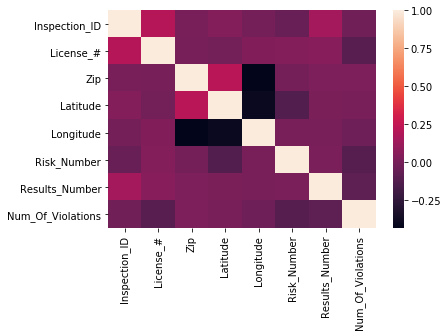

In [188]:
#correlation between numerical values
ax = sns.heatmap(restaurants.corr());

In [189]:
#covariance between numercial variables
restaurants.cov()

,Inspection_ID,License_#,Zip,Latitude,Longitude,Risk_Number,Results_Number,Num_Of_Violations
Inspection_ID,3.495359e+11,1.022667e+11,76298.657968,2124.193629,-107.131150,-12468.450138,108183.814811,-27773.797070
License_#,1.022667e+11,7.188953e+11,22054.175559,-785.296982,1728.671279,16299.630573,57054.303265,-251833.791429
Zip,7.629866e+04,2.205418e+04,376.128609,0.317090,-0.501217,-0.048680,0.564871,1.393359
Latitude,2.124194e+03,-7.852970e+02,0.317090,0.005668,-0.001784,-0.004273,0.001728,0.001752
Longitude,-1.071311e+02,1.728671e+03,-0.501217,-0.001784,0.003551,0.000200,0.000254,-0.004590
Risk_Number,-1.246845e+04,1.629963e+04,-0.048680,-0.004273,0.000200,0.187183,0.006415,-0.144618
Results_Number,1.081838e+05,5.705430e+04,0.564871,0.001728,0.000254,0.006415,1.408664,-0.293406
Num_Of_Violations,-2.777380e+04,-2.518338e+05,1.393359,0.001752,-0.004590,-0.144618,-0.293406,8.672938


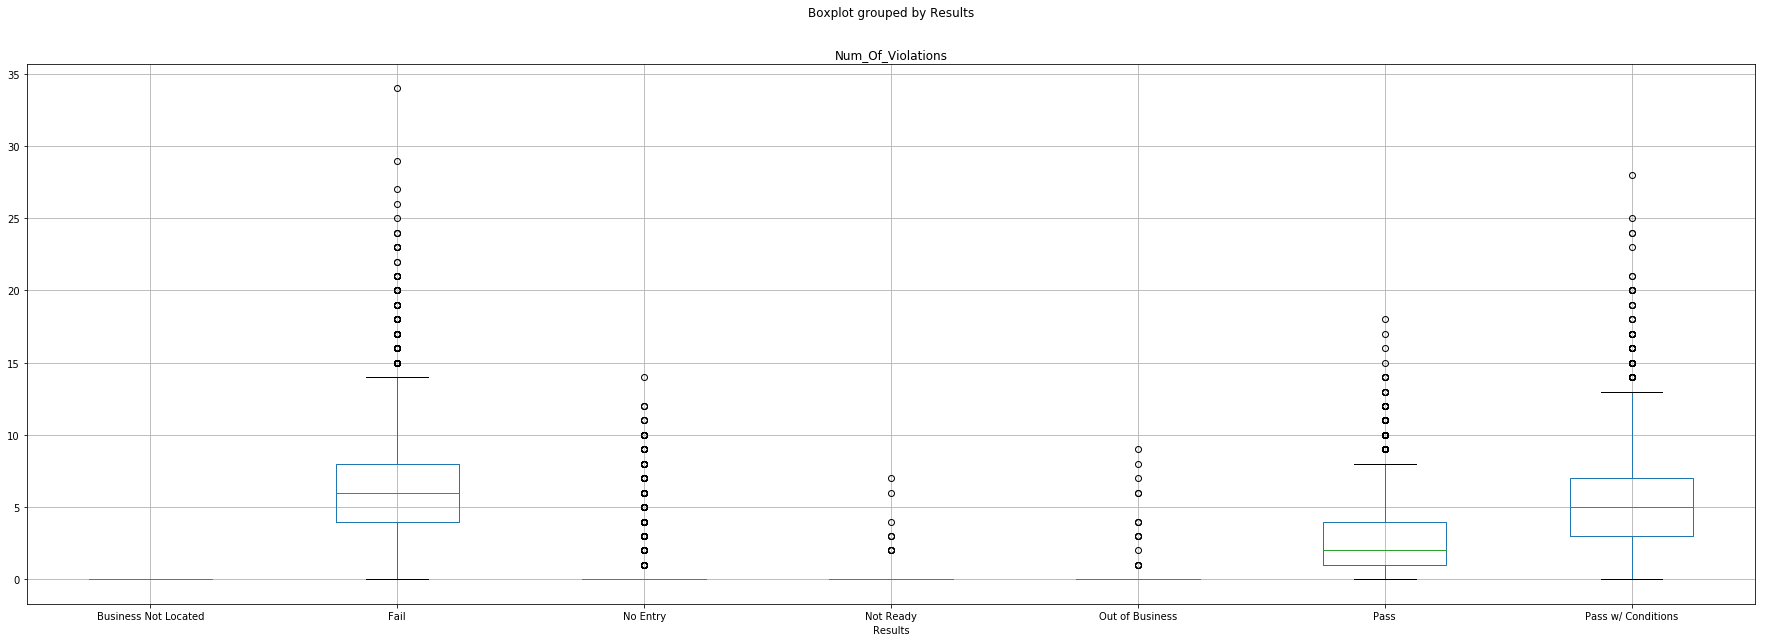

In [190]:
#boxplot of number of violations by results 

ax = restaurants.boxplot(column=['Num_Of_Violations'], by='Results',figsize=(30,10))
ax

In [191]:
#checking data types of restaurant subset data

restaurants.dtypes

Inspection_ID          int64
DBA_Name              object
AKA_Name              object
License_#            float64
Facility_Type         object
Risk                  object
Address               object
City                  object
State                 object
Zip                  float64
Inspection_Date       object
Inspection_Type       object
Results               object
Violations            object
Latitude             float64
Longitude            float64
Location              object
Violations_New        object
Risk_Number          float64
Results_Number         int64
Num_Of_Violations    float64
dtype: object


#### Determine how to handle sampling or missing values.

There is a large sample size, however, there are multiple categorical data flaws. Primarily, inaccurate inspection types that deviated from acceptable responsed muddled the data. However, I dropped this data in order to accurate inspection type data. Additionaly, my categorical
values need to be mapped to numerical variables for comparison. 

Missing values will either be dropped, or assigned a null value, if they don't apply to the anaysis. An example of this is the calculation for Number of violations. (inspections['Num_Of_Violations'].fillna(0, inplace=True)

#### Clearly identify shortcomings, assumptions, and next steps.

Shortcomings: 
    Number of violations will have to be paired with other cofounding variables in order to predict if a business will shut down
     All of my contextual values will have to mapped to numerical values
    
Assumptions:
    All data from 2010 - present will be used to predict if a  business will shut down 
    Only data from Chicago restaurants will be used (all data from other establishments will be parsed out
    Number of violations per restaurant is a calculation and not a given numercial value in the data set
    
    
Next Steps:
    Consider contextual variables (text analysis of violations) and potentially geo location data to back into predictions
    Consider other numerical variables in my prediction
    Begin model analysis
    Continue with further EDA(text analysis)
    
    

## Choose a Model

## Logistic Regression

In [192]:

from sklearn.linear_model import LogisticRegression

restaurants_reset = restaurants.reset_index()
LR = LogisticRegression()
X = restaurants_reset.loc[:, ['Num_Of_Violations','Risk_Number']]
y = restaurants_reset.loc[:, 'Results_Number'] == 1

In [193]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [194]:
LR.fit(X_train,y_train)

y_pred = LR.predict(X_test)

LR.score(X_test, y_test)

0.6664176063034913

In [195]:
# Compare to null model
# /scrub/
y_pred_null = np.zeros(y_test.shape) + y_train.mean() > .5
metrics.accuracy_score(y_test, y_pred_null)

0.573427523434316

In [196]:
# Store the predicted probabilities of class 1.
# /scrub/
restaurants_copy = restaurants.copy()
restaurants_copy.loc[:, 'results_pred_prob'] = LR.predict_proba(X)[:, 1]

In [197]:
restaurants_copy.head(50)

,Inspection_ID,DBA_Name,AKA_Name,License_#,Facility_Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Violations_New,Risk_Number,Results_Number,Num_Of_Violations,results_pred_prob
1,2233116,LOST LARSON,LOST LARSON,2627751.0,Restaurant,Risk 2 (Medium),5318 N CLARK ST,CHICAGO,IL,60640.0,...,Pass w/ Conditions,NaN,41.978685,-87.668467,"(41.97868454005666, -87.6684667325925)",,2.0,3,0.0,0.686400
2,2233074,NHA TRANG RESTAURANT,NHA TRANG RESTAURANT,2595497.0,Restaurant,Risk 1 (High),1104-1106 W ARGYLE ST,CHICAGO,IL,60640.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.973379,-87.657999,"(41.97337889982834, -87.65799855526953)","3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",1.0,3,3.0,0.596659
3,2233069,LAKEVIEW REWIRED CAFE,LAKEVIEW REWIRED CAFE,2601553.0,Restaurant,Risk 2 (Medium),3508 N BROADWAY,CHICAGO,IL,60657.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945711,-87.646435,"(41.94571075549612, -87.64643499671985)",5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,2.0,3,3.0,0.563845
5,2233055,"GATELY SEAFOOD MARKET, INC.","GATELY SEAFOOD MARKET, INC.",2609804.0,Restaurant,Risk 1 (High),11201 S MICHIGAN AVE,CHICAGO,IL,60628.0,...,Pass,NaN,41.690750,-87.620880,"(41.69075019344447, -87.6208804369684)",,1.0,1,0.0,0.714660
6,2233050,FRESH BREW,FRESH BREW,2589819.0,Restaurant,Risk 2 (Medium),2410 W BRYN MAWR AVE,Chicago,IL,60659.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.983276,-87.689929,"(41.98327599959104, -87.68992858007628)","3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2.0,3,7.0,0.390479
8,2233040,DAVID'S MARKET,DAVID'S MARKET,2595978.0,Restaurant,Risk 3 (Low),6033 N SHERIDAN RD,CHICAGO,IL,60660.0,...,Pass,NaN,41.991929,-87.655296,"(41.99192875594554, -87.65529639558433)",,3.0,1,0.0,0.656685
9,2232937,"WILSON WINGS, INC/WINGSTOP RESTAURANT",WINGSTOP,2621302.0,Restaurant,Risk 2 (Medium),4547 N BROADWAY,CHICAGO,IL,60640.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.964981,-87.657043,"(41.96498064673003, -87.65704319788571)",5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,2.0,3,2.0,0.606423
10,2233036,THE SUBMARINE PIER,THE SUBMARINE PIER,2359484.0,Restaurant,Risk 1 (High),2759 W 51ST ST,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.800881,-87.693935,"(41.80088086731136, -87.69393527317897)","3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",1.0,3,5.0,0.510130
11,2233038,FIREHOUSE BAKERY AND GRILL,FIREHOUSE BAKERY AND GRILL,2631832.0,Restaurant,Risk 1 (High),720 E 75TH ST,CHICAGO,IL,60619.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.758663,-87.606945,"(41.75866330130953, -87.60694480931582)",5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,1.0,3,5.0,0.510130
12,2233030,TORO SUSHI INC.,TORO SUSHI,1617746.0,Restaurant,Risk 1 (High),2546 N CLARK ST,CHICAGO,IL,60614.0,...,No Entry,NaN,41.928957,-87.642640,"(41.9289565890134, -87.6426397468366)",,1.0,5,0.0,0.714660


In [198]:

# Examine the predicted probabilities for the first handful of rows of `X`.
# /scrub/
LR.predict_proba(X)[0:10]



array([[0.31360041, 0.68639959],
       [0.40334058, 0.59665942],
       [0.43615511, 0.56384489],
       [0.28534025, 0.71465975],
       [0.6095206 , 0.3904794 ],
       [0.34331491, 0.65668509],
       [0.39357702, 0.60642298],
       [0.48986995, 0.51013005],
       [0.48986995, 0.51013005],
       [0.28534025, 0.71465975]])

Sklearn orders the columns according to our class labels. The two-column output of predict_proba returns a column for each class of our household variable. The first column is the probability of household=0 for a given row, and the second column is the probability of household=1

### Natural Language Processing (Naive Bayes)

In [300]:
#2. Load in the Sentiment IntensityAnalyzer from Vader and add compound, negative, neutral, and positive scores into the DataFrame.

import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clarissa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [350]:
results_best_worst = restaurants.loc[(restaurants.loc[:, 'Results_Number'] == 1) | (restaurants.loc[:, 'Results_Number'] == 4), :]

In [351]:
results_best_worst.shape

(75809, 21)

In [352]:
X = results_best_worst.loc[:, 'Violations_New']
y = results_best_worst.loc[:, 'Results_Number']

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [354]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [355]:
# Transformed feature matrices are stored as sparse matrices for efficiency.

# A sparse representation stores the vaues and locations of non-zero elements,
# rather than storing a number for every element, which saves space when
# most elements are zero.
# /scrub/
X_train_dtm

<56856x12348 sparse matrix of type '<class 'numpy.int64'>'
	with 2953981 stored elements in Compressed Sparse Row format>

In [356]:
# View as a dense matrix
X_train_dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [357]:
# Rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).
# /scrub/
X_train_dtm.shape

(56856, 12348)

In [358]:
# Last 50 features
# /scrub/
print((vect.get_feature_names()[-50:]))

['wrong', 'wrought', 'wshbowl', 'wshhroom', 'wsprayer', 'wter', 'wth', 'wthout', 'wtih', 'wtihin', 'wxterior', 'x1', 'x2', 'x3', 'x4', 'yables', 'yagihashi', 'yard', 'year', 'years', 'yeast', 'yellow', 'yellowing', 'yellowish', 'yesterday', 'yet', 'yhe', 'yo', 'yogenfruz', 'yoghurt', 'yogurt', 'yogurts', 'you', 'yougarts', 'young', 'your', 'yoxic', 'ypper', 'ytensils', 'yucca', 'zamudio', 'ze', 'zip', 'zipcode', 'ziploc', 'ziplock', 'zipping', 'zodiac', 'zone', 'zurich']


In [359]:
# Take a look at the vocabulary that was generated
#   'vocabulary_' is a dictionary that converts each word to its index in the sparse matrix.
# /scrub/
vect.vocabulary_

{'32': 330,
 'food': 4813,
 'and': 942,
 'non': 7395,
 'contact': 2888,
 'surfaces': 10840,
 'properly': 8581,
 'designed': 3521,
 'constructed': 2872,
 'maintained': 6749,
 'comments': 2662,
 'observed': 7509,
 'door': 3859,
 'of': 7564,
 'dessert': 3528,
 'cooler': 3039,
 'in': 5744,
 'disrepair': 3800,
 'repair': 9096,
 'maintain': 6743,
 'cutting': 3321,
 'boards': 1622,
 'with': 12217,
 'dark': 3366,
 'grooves': 5284,
 'clean': 2414,
 'sanitize': 9586,
 'so': 10247,
 'that': 11035,
 'come': 2654,
 'out': 7752,
 'or': 7675,
 'replace': 9128,
 'reach': 8776,
 'coolers': 3050,
 'behind': 1474,
 'cooking': 3015,
 'line': 6554,
 'doors': 3868,
 'duct': 4003,
 'tape': 10960,
 'cracked': 3193,
 'plastic': 8164,
 'on': 7607,
 'interior': 6047,
 'remove': 9045,
 'all': 857,
 'freezer': 4914,
 'basemnt': 1381,
 'prep': 8368,
 'room': 9397,
 'escess': 4319,
 'ice': 5676,
 'accumulation': 697,
 'defrost': 3453,
 '35': 346,
 'walls': 11981,
 'ceilings': 2180,
 'attached': 1158,
 'equipment': 4

In [360]:
# Show vectorizer options.
# /scrub/
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [361]:
# Create document-term matrices using default options for CountVectorizer.
# /scrub/
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [362]:
# Use Naive Bayes to predict the result number.
# /scrub/
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

In [387]:
# Calculate accuracy.
# /scrub/
print((metrics.accuracy_score(y_test, y_pred_class)))
#calculate precision
print ((metrics.precision_score(y_test, y_pred_class)))

0.8979053448002955
0.8980474934036939


In [364]:
# Check label balnce
# /scrub/
y_test.value_counts()

1    17021
4     1932
Name: Results_Number, dtype: int64

In [418]:

# Calculate null accuracy.
# /scrub/
y_test_binary = np.where(y_test==4, 1, 0) # out of business become 4, pass becomes 1
print('Out of Business:', y_test_binary.mean())
print('Pass Inspection:', 1 - y_test_binary.mean())

Out of Business: 0.10193636891257321
Pass Inspection: 0.8980636310874268
